In [1]:
import sys
sys.path.insert(0, '../../../Utilities/')
import argparse
import os
import torch
from collections import OrderedDict
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import seaborn as sns
import pylab as py
import time
from doe_lhs import *
import warnings
sys.path.insert(0, '../../../Scripts/')
from models_pde import Net
from pinn import *
# from ../Scripts/helper import *

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
num_epochs = 60000
lambda_phy = 1

noise = 0.0

## Network Architecture
hid_dim = 128
num_layer = 4


In [4]:
# Doman bounds
lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1.0])

N0 = 512
N_b = 100
N_f = 10000
# layers = [2, 100, 100, 100, 100, 2]

data = scipy.io.loadmat('AC.mat')

t = data['tt'].flatten()[:,None] # 201
x = data['x'].flatten()[:,None]  # 512
Exact = np.real(data['uu'])

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.T.flatten()[:,None]

###########################


############################


lb = X_star.min(0) 
ub = X_star.max(0) 


# --------------------- first half ---------------------

# initial points
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0_1 = x[idx_x,:]
u0_1 = Exact[idx_x,0:1]

# boundary points
idx_t = np.random.choice(t.shape[0], N_b, replace=True)
tb_1 = t[idx_t,:]

# collocation points
X_f_1 = lb + (ub-lb)*lhs(2, N_f)


X0_1 = np.concatenate((x0_1, 0*x0_1), 1) # (x0, 0)
Y0_1 = u0_1 
X_lb_1 = np.concatenate((0*tb_1 + lb[0], tb_1), 1) # (lb[0], tb)
X_ub_1 = np.concatenate((0*tb_1 + ub[0], tb_1), 1) # (ub[0], tb)


In [5]:
net = Net(in_dim = 2, out_dim = 1, hid_dim = hid_dim, num_layers = num_layer).to(device)

ACs = PINN(X0_1, Y0_1, X_f_1, X_lb_1, X_ub_1, net, device, num_epochs, lambda_phy, noise)
 
ACs.train()

[Epoch 0/60000] [MSE loss: 0.137769] [Phy loss: 0.033559] [Total loss: 0.180218]
[Epoch 100/60000] [MSE loss: 0.135530] [Phy loss: 0.002813] [Total loss: 0.138788]
[Epoch 200/60000] [MSE loss: 0.134072] [Phy loss: 0.003097] [Total loss: 0.137778]
[Epoch 300/60000] [MSE loss: 0.132156] [Phy loss: 0.003659] [Total loss: 0.136940]
[Epoch 400/60000] [MSE loss: 0.130057] [Phy loss: 0.004707] [Total loss: 0.136100]
[Epoch 500/60000] [MSE loss: 0.128695] [Phy loss: 0.005836] [Total loss: 0.135344]
[Epoch 600/60000] [MSE loss: 0.127985] [Phy loss: 0.006340] [Total loss: 0.134897]
[Epoch 700/60000] [MSE loss: 0.127762] [Phy loss: 0.006241] [Total loss: 0.134470]
[Epoch 800/60000] [MSE loss: 0.126136] [Phy loss: 0.007298] [Total loss: 0.133784]
[Epoch 900/60000] [MSE loss: 0.124274] [Phy loss: 0.008945] [Total loss: 0.133444]
[Epoch 1000/60000] [MSE loss: 0.124000] [Phy loss: 0.008738] [Total loss: 0.132917]
[Epoch 1100/60000] [MSE loss: 0.123761] [Phy loss: 0.008710] [Total loss: 0.132660]
[Epo

KeyboardInterrupt: 

In [ ]:
u_pred_list = []
f_pred_list = []

for run in range(1):
    u_pred, f_pred = ACs.get_residual(X_star)
    u_pred_list.append(u_pred.detach().cpu().numpy())
    f_pred_list.append(f_pred.detach().cpu().numpy())

u_pred_arr = np.array(u_pred_list)
f_pred_arr = np.array(f_pred_list)
u_pred = u_pred_arr.mean(axis=0)
f_pred = f_pred_arr.mean(axis=0)
u_dev = u_pred_arr.var(axis=0)
f_dev = f_pred_arr.var(axis=0)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     
print('Residual: %e' % (f_pred**2).mean())
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
U_dev = griddata(X_star, u_dev.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred.T)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'U_pred' is not defined

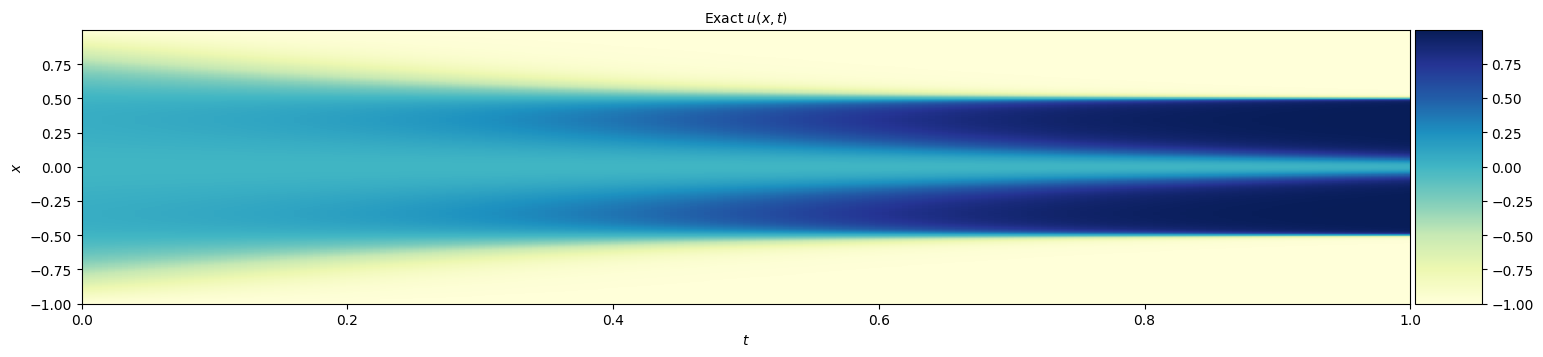

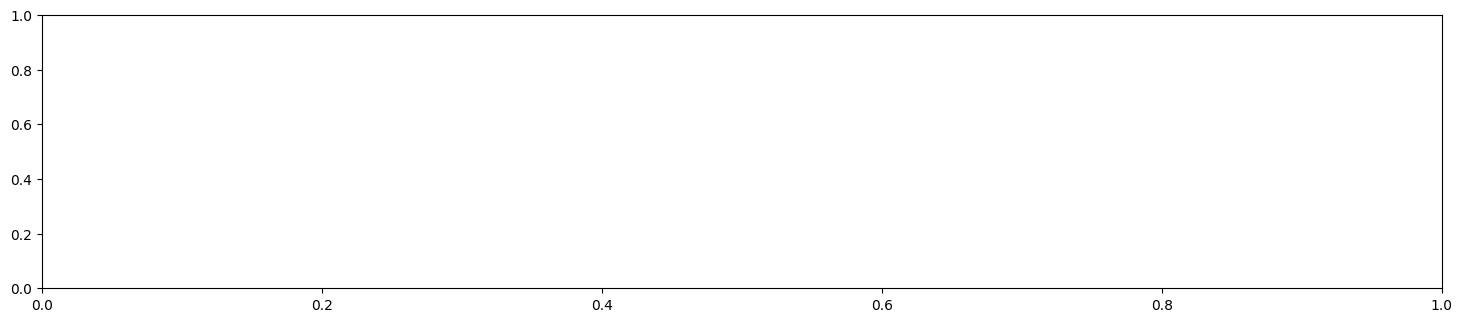

In [6]:
######################################################################
############################# Plotting ###############################
######################################################################    
# t = data['tt'].flatten()[:,None]
# x = data['x'].flatten()[:,None]

# X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
# X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
# X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
# X_u_train = np.vstack([X0, X_lb, X_ub])

# fig, ax = newfig(1.0, 0.9)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('Exact $u(x,t)$', fontsize = 10)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

# error  = griddata(X_star, np.abs(u_star-U_pred).flatten(), (X, T), method='cubic')


h = ax.imshow(np.abs(Exact - U_pred.T), interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')



# h = ax.imshow(U_pred.T, interpolation='nearest', cmap='YlGnBu', 
#               extent=[lb[1], ub[1], lb[0], ub[0]], 
#               origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

  

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('Prediction $u(x,t)$', fontsize = 10)


